<a href="https://colab.research.google.com/github/RifalAlmohammadi-cs/ADHD_Classifer/blob/main/ResNet18_ADHD_Classifier_Rafolah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1st/

import all needed libraries

In [ ]:
pip install split-folders

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
import splitfolders   #to split the data automatically
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np

#because of the problem we got in prediction we'll set seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.listdir()

['.config', 'sample_data']

# 2nd/

Set the dataset directory and split the data

In [ ]:
input_file='/content/drive/MyDrive/DAP_only'     #Path of the folder we want to split
output_file='/content/drive/MyDrive/DAP__Only(splited)' #Folder path after splitting

splitfolders.ratio(input_file,
                   output=output_file,
                   seed=30,            #This is a random seed to ensure that the dataset split is reproducible
                   ratio=(0.7,0.3),    #0.7 for trainig , 0.3 for validation
                   group_prefix=None)

#we'll not need the path of the folders
#train_path= "/content/drive/MyDrive/NewDataset/train"
#val_path= "/content/drive/MyDrive/NewDataset/val"

Copying files: 231 files [00:43,  5.26 files/s]


# 3rd/

Define data transformation to preform data augmentation and normalization on our dataset

In [ ]:
data_transforms ={
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),    #randomly resize and crop all input images to 224*224
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),                #transform all images to tensor value --> important step
                                              #because pytorch accepts only the data in tensor format
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 4th/

Loading the dataset

In [ ]:
#define the data directory
data_dir='/content/drive/MyDrive/DAP__Only(splited)'

# Ensure the dataset directory and subdirectories (train, val) exist
os.makedirs(os.path.join(data_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(data_dir, 'val'), exist_ok=True)

#create data loaders --> to load the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

#print the classes names
class_names = image_datasets['train'].classes
class_names

{'train': 161, 'val': 70}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


['have_ADHD', 'normal']

# 5th/

Load and prepare the pre-trained model (ResNet18)

In [ ]:
#load ResNet18
model=models.resnet18(pretrained=True)

#freeze all layers except the final classification layer
for name, param in model.named_parameters():
  if 'fc' in name:      #Unfreeze the final classification layer
    param.requires_grad=True
  else:
    param.requires_grad=False

#define the loss function and optimizer
criterion = nn.CrossEntropyLoss()    #crossEntropy --> the most commonly used method to calculate loss in classification problems

#SGD(Stochastic Gradient Descent) --> is a variant of the Gradient Descent, instead of using the entire dataset for each iteration,
#only a single random training example (or a small batch) is selected to calculate the gradient and update the model parameters.
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4) #we can change the parameters to enhance the accuracy of the model
# Implement Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) # Reduces LR every 5 epochs

#move the model to the GPU if it's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model.to(device)

# 6th/

Start training the model

In [ ]:
#in this block of code we'll: train the model - update the weightes - get the accuracy & loss - get the accuracy & loss
#Initialize Lists to Store Data
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

import datetime
t0=datetime.datetime.now()

#Training loop
num_epochs = 20
for epoch in range(num_epochs):
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else:
      model.eval()

#these two variables will store the loss and the correct predictions inside every epoch
    running_loss=0.0
    running_corrects=0

    for inputs, labels in dataloaders[phase]:
      # ***.to(device) --> means sending our inputs and labels where we want to handle the training process (CPU or GPU)
      inputs=inputs.to(device)   #inputs --> mean our input images
      labels=labels.to(device)   #labels --> mean our classes

      optimizer.zero_grad()      #clear the optimizer from gradient value from the previous iteration

#in the training phase:
      with torch.set_grad_enabled(phase=='train'):
        outputs=model(inputs)             #provide input images to the model
        _, preds=torch.max(outputs,1)     #showing the prediction
        loss=criterion(outputs, labels)   #getting the loss

        if phase=='train':
          loss.backward()   #in backward pass --> we calculate the gradient and update the weighte, after that we go with the forward pass to retrain the model on the updated weightes
          optimizer.step()  #in this line we updating the weights

      running_loss+=loss.item()*inputs.size(0)
      running_corrects+=torch.sum(preds==labels.data)

    epoch_loss=running_loss/dataset_sizes[phase]
    epoch_acc=running_corrects.double()/dataset_sizes[phase]

#append loss and acc values fro plotting
    if phase=='train':
      train_losses.append(epoch_loss)
      train_accuracies.append(epoch_acc)
      scheduler.step()  # Update learning rate
    else:
      val_losses.append(epoch_loss)
      val_accuracies.append(epoch_acc)

    print(f'Epoch:{epoch+1}/{num_epochs}   {phase}   Loss: {epoch_loss:.4f}   Accuracy: {epoch_acc:.4f}')

t1=datetime.datetime.now()
print("Training complete!", "time duration to train ", (t1-t0))

Epoch:1/20   train   Loss: 5.8064   Accuracy: 0.2236
Epoch:1/20   val   Loss: 3.7607   Accuracy: 0.3571
Epoch:2/20   train   Loss: 1.6010   Accuracy: 0.6460
Epoch:2/20   val   Loss: 1.1694   Accuracy: 0.7000
Epoch:3/20   train   Loss: 0.8673   Accuracy: 0.6584
Epoch:3/20   val   Loss: 0.8484   Accuracy: 0.7714
Epoch:4/20   train   Loss: 0.7500   Accuracy: 0.7019
Epoch:4/20   val   Loss: 0.7449   Accuracy: 0.7714
Epoch:5/20   train   Loss: 0.8030   Accuracy: 0.6770
Epoch:5/20   val   Loss: 0.7197   Accuracy: 0.7714
Epoch:6/20   train   Loss: 0.7573   Accuracy: 0.6646
Epoch:6/20   val   Loss: 0.7305   Accuracy: 0.7429
Epoch:7/20   train   Loss: 0.7462   Accuracy: 0.6335
Epoch:7/20   val   Loss: 0.6899   Accuracy: 0.7143
Epoch:8/20   train   Loss: 0.5979   Accuracy: 0.7329
Epoch:8/20   val   Loss: 0.6386   Accuracy: 0.7714
Epoch:9/20   train   Loss: 0.7093   Accuracy: 0.6957
Epoch:9/20   val   Loss: 0.6473   Accuracy: 0.8000
Epoch:10/20   train   Loss: 0.7083   Accuracy: 0.6646
Epoch:10/2

# 7th/
Saving the model

In [ ]:
torch.save(model.state_dict(), 'ADHD_Classification_model.pth')

# 8th/
ploting the model

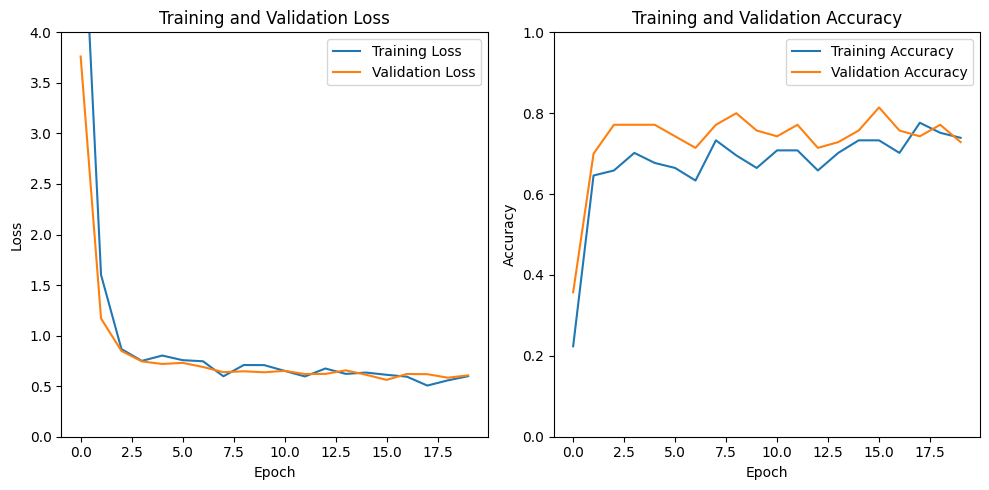

In [ ]:
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)      #subplots -->  to display loss and accuracy graphs side-by-side for easy comparison
plt.ylim(0.0, 4.0)       #set the y-axis limits before showing the plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.ylim(0.0, 1.0)       #set the y-axis limits before showing the plot
# Convert tensors to NumPy arrays after moving them to CPU
plt.plot([x.cpu().numpy() for x in train_accuracies], label='Training Accuracy')
plt.plot([x.cpu().numpy() for x in val_accuracies], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# **Now let's try the model !**

We'll use the saved model to classify unseen images, and to do that we need:


1.   load the model
2.   apply it to new images

In [ ]:
#import needed libraries
from PIL import Image

#load the seved model
model=models.resnet18(pretrained=True)
#adjust to match the original model's output unit
model.fc=nn.Linear(model.fc.in_features, 1000)
model.load_state_dict(torch.load('ADHD_Classification_model.pth'))
model.eval()

#create a new model with correct final layer
new_model=models.resnet18(pretrained=True)
#adjust to match the desired output unit
model.fc=nn.Linear(model.fc.in_features, 2)     # 2 --> the number of classes

#copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data=model.fc.weight.data[0:2]      #copy only the first 2 output units
new_model.fc.bias.data=model.fc.bias.data[0:2]

#load and preprocess prepare the unseen image for classification
image_path='/content/drive/MyDrive/DAP_MS042.jpg'
image=Image.open(image_path).convert('RGB')
preprocess=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor=preprocess(image)
input_batch=input_tensor.unsqueeze(0)     #add a batch dimension

#Move the model to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)           #Make sure model is on the correct device
new_model = new_model.to(device)   #Make sure new_model is on the correct device

<ipython-input-12-ccf3edba2743>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ADHD_Classification_model.pth'))


# **Now let's start testing**

(any time we got wrong prediction restart the session because the cache is full --> there is no problem with the model)

In [ ]:
#warm-up the model before getting the prediction (because of the problem we got in prediction)
for _ in range(5):
  with torch.no_grad():
    _ = model(torch.randn(1, 3, 224, 224).to(device))

#(because of the problem we got in prediction we will implement multiple predictions with averaging:)
#in the following block of code we'll run the prediction process multiple times with the same
#input image and then average the predicted probabilities or class labels to obtain a more robust prediction
#that 'll reduce the impact of randomness in the model's behavior, leading to a more stable and potentially more accurate prediction.

num_predictions = 5   #number of predictions to average
#perform multiple predictions and store the results
predictions = []
for _ in range(num_predictions):
  with torch.no_grad():
    output = model(input_batch.to(device))
  # Get predicted probabilities
  probabilities = torch.nn.functional.softmax(output, dim=1)
  predictions.append(probabilities.cpu().numpy()) # Move to CPU for NumPy

#average the predictions
averaged_prediction = np.mean(predictions, axis=0)

#get the predicted class from the averaged prediction
predicted_class = np.argmax(averaged_prediction)

#map the predicted class to the class name
class_names=['Have_ADHD','Normal']
predicted_class_name=class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: Have_ADHD


let's display our image with it's class

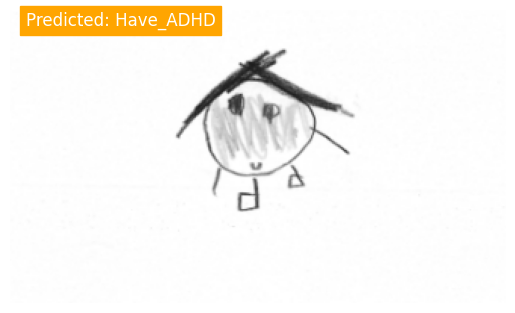

In [ ]:
import numpy as np

#display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10,10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='orange')
plt.show()